In [18]:
# import necessary libraries
import numpy as np
import pandas as pd
import json
import os 
from scipy.cluster.hierarchy import ward, dendrogram
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import string
from wordcloud import WordCloud


# options for display of pd dfs
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)

In [2]:
# import dfs 
df_occ_skills = pd.read_json('Data/ESCO_occup_skills.json') 
df_skills = pd.read_csv('Data/skills_en.csv')
df_occ = pd.read_csv('Data/occupations_en.csv')

In [3]:
# from the df_occ_skills we want to create a df which has each occupation stored as a row and column of this will be a list of hasEssentialSkill
# Thus we create to lists which will later function as columns in the final
occupation_full_list = [] # stores all 2,942 occupations
skills_essential_full_list = [] # stores all essential skills for all 2,942 occupations
#skills_optional_full_list = [] # we can expand the approach to also store optional skills

for i in df_occ_skills.columns: # we use a loop to fill our previously create lists
    skills_essential = []
    #skills_optional = []
    if any([i == 'specialist dentist']): # during the analysation we can see that some occupations don't have hasEssentialSkill or hasOptionalSkill
        occupation_full_list.append(i)   # thus we have to implement a dummy in for their skills. Only the special dentist has no essential skills in our data
        skills_essential_full_list.append("...")
    else:
        for j in range(0,len(df_occ_skills[i]['_links']['hasEssentialSkill'])): # for each occupation we iterate through the essential skills and store them in a list 
            skill_essential = df_occ_skills[i]['_links']['hasEssentialSkill'][j]['title']
            skills_essential.append(skill_essential)
        occupation_full_list.append(i)                      # finally we can append occupation and the list of skills to our previously created list
        skills_essential_full_list.append(skills_essential)
    #if any([i == 'technical director', i == 'tobacco shop manager', i=='rental service representative in agricultural machinery and equipment']):
    #    skills_optional_full_list.append("...")
    #else:    
    #    for k in range(0,len(df_occ_skills[i]['_links']['hasOptionalSkill'])):
    #        skill_optional = df_occ_skills[i]['_links']['hasOptionalSkill'][k]['title']
    #        skills_optional.append(skill)

    #skills_optional_full_list.append(skills_optional)

df = pd.DataFrame(list(zip(occupation_full_list, skills_essential_full_list)), columns =['occupation', 'skills_essential']) # we use both lists to create the foundation for our df
df = df.merge(df_occ, left_on='occupation', right_on='preferredLabel') # we join our dataframe with df_occ to get a description and ISCO number into our newly created df
df = df[['iscoGroup', 'occupation', 'description', 'skills_essential']]
df = df.rename(columns={"iscoGroup": "iscogroup", "description": "occupation_description"})

df['all_data'] = '' # we add a column called all data we store all text information about a occupation in here, further we preprocess our data and filter for any punctuation
#df['skills_essential_listform'] = df["skills_essential"]
df.all_data = df.apply(lambda x: str(x.occupation_description) + ' ' + str(x.skills_essential), axis=1)
df.all_data = df.apply(lambda x: "".join(c for c in x['all_data'] if c not in string.punctuation),axis=1)
df.skills_essential = df.apply(lambda x: " ".join(str(c) for c in x['skills_essential']),axis=1)
#df.all_data = df.apply(lambda x: x.all_data.replace('\n',' '),axis=1)

(2942, 5380)


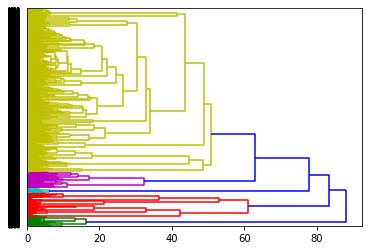

In [7]:
# we create a corpus which will be the basis for our tf-idf matrix (term frequency–inverse document frequency)
corpus = [] # the corpus stores all information we want to use to cluster the occupations, the analysis show that only using the words of
            # the essential skills is most effective, while using a combination of occupation description and essential skills seems to confuse the algorithm 
for s in df.skills_essential: # we iterate through all essential skills and store the text in a 
    s = "".join(c for c in s if c not in string.punctuation)
    corpus.append(s)

# we define the parameters of our vectorizer, in simple words we implement certain criteria about which words vectorizer will use.
# I found that using a simple vectorizer will yield the best results, thus each word which appears once will be included in the matrix
# In the next cell i tried out various settings, further below it can be seen how tuning of the vectorizer and the basis of the corpus effect the resulting clusters
vectorizer = TfidfVectorizer(min_df=1, stop_words="english")                                                            
tfidf_matrix = vectorizer.fit_transform(corpus) # use vectrizer on corpus
print(tfidf_matrix.shape) #shape indicates number of occupations x number of  unique used words found by the vectorizer 

feature_names = vectorizer.get_feature_names() # gets names of words used as features

dist = 1 - cosine_similarity(tfidf_matrix) # we define the distance using the cosine similarity

# as we want to see a hiararchy in clustering I choose the ward algorithm and visualised my results with a dendrogram 
linkage_matrix = ward(dist) # with the ward distance we obtain a structure which combines the two most similar points with each other 
                            # till only a single cluster is left, the object linkage_matrix shows which points combine to a cluster a what stage
den = dendrogram(linkage_matrix, orientation="right", get_leaves=True) # we can visualize this matrix using a dendrogram

In [ ]:
#works similiar to the cell above and was used to find out more about the optimal corpus and vectorizer settings
corpus = []
for s in df.skills_essential:
    s = "".join(c for c in s if c not in string.punctuation)
    corpus.append(s)
    
vectorizer = TfidfVectorizer(max_df=0.10, min_df=2,max_features=200000, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(corpus)
print(tfidf_matrix.shape)

feature_names = vectorizer.get_feature_names()
dist = 1 - cosine_similarity(tfidf_matrix)
linkage_matrix = ward(dist)
den = dendrogram(linkage_matrix, orientation="right", get_leaves=True)

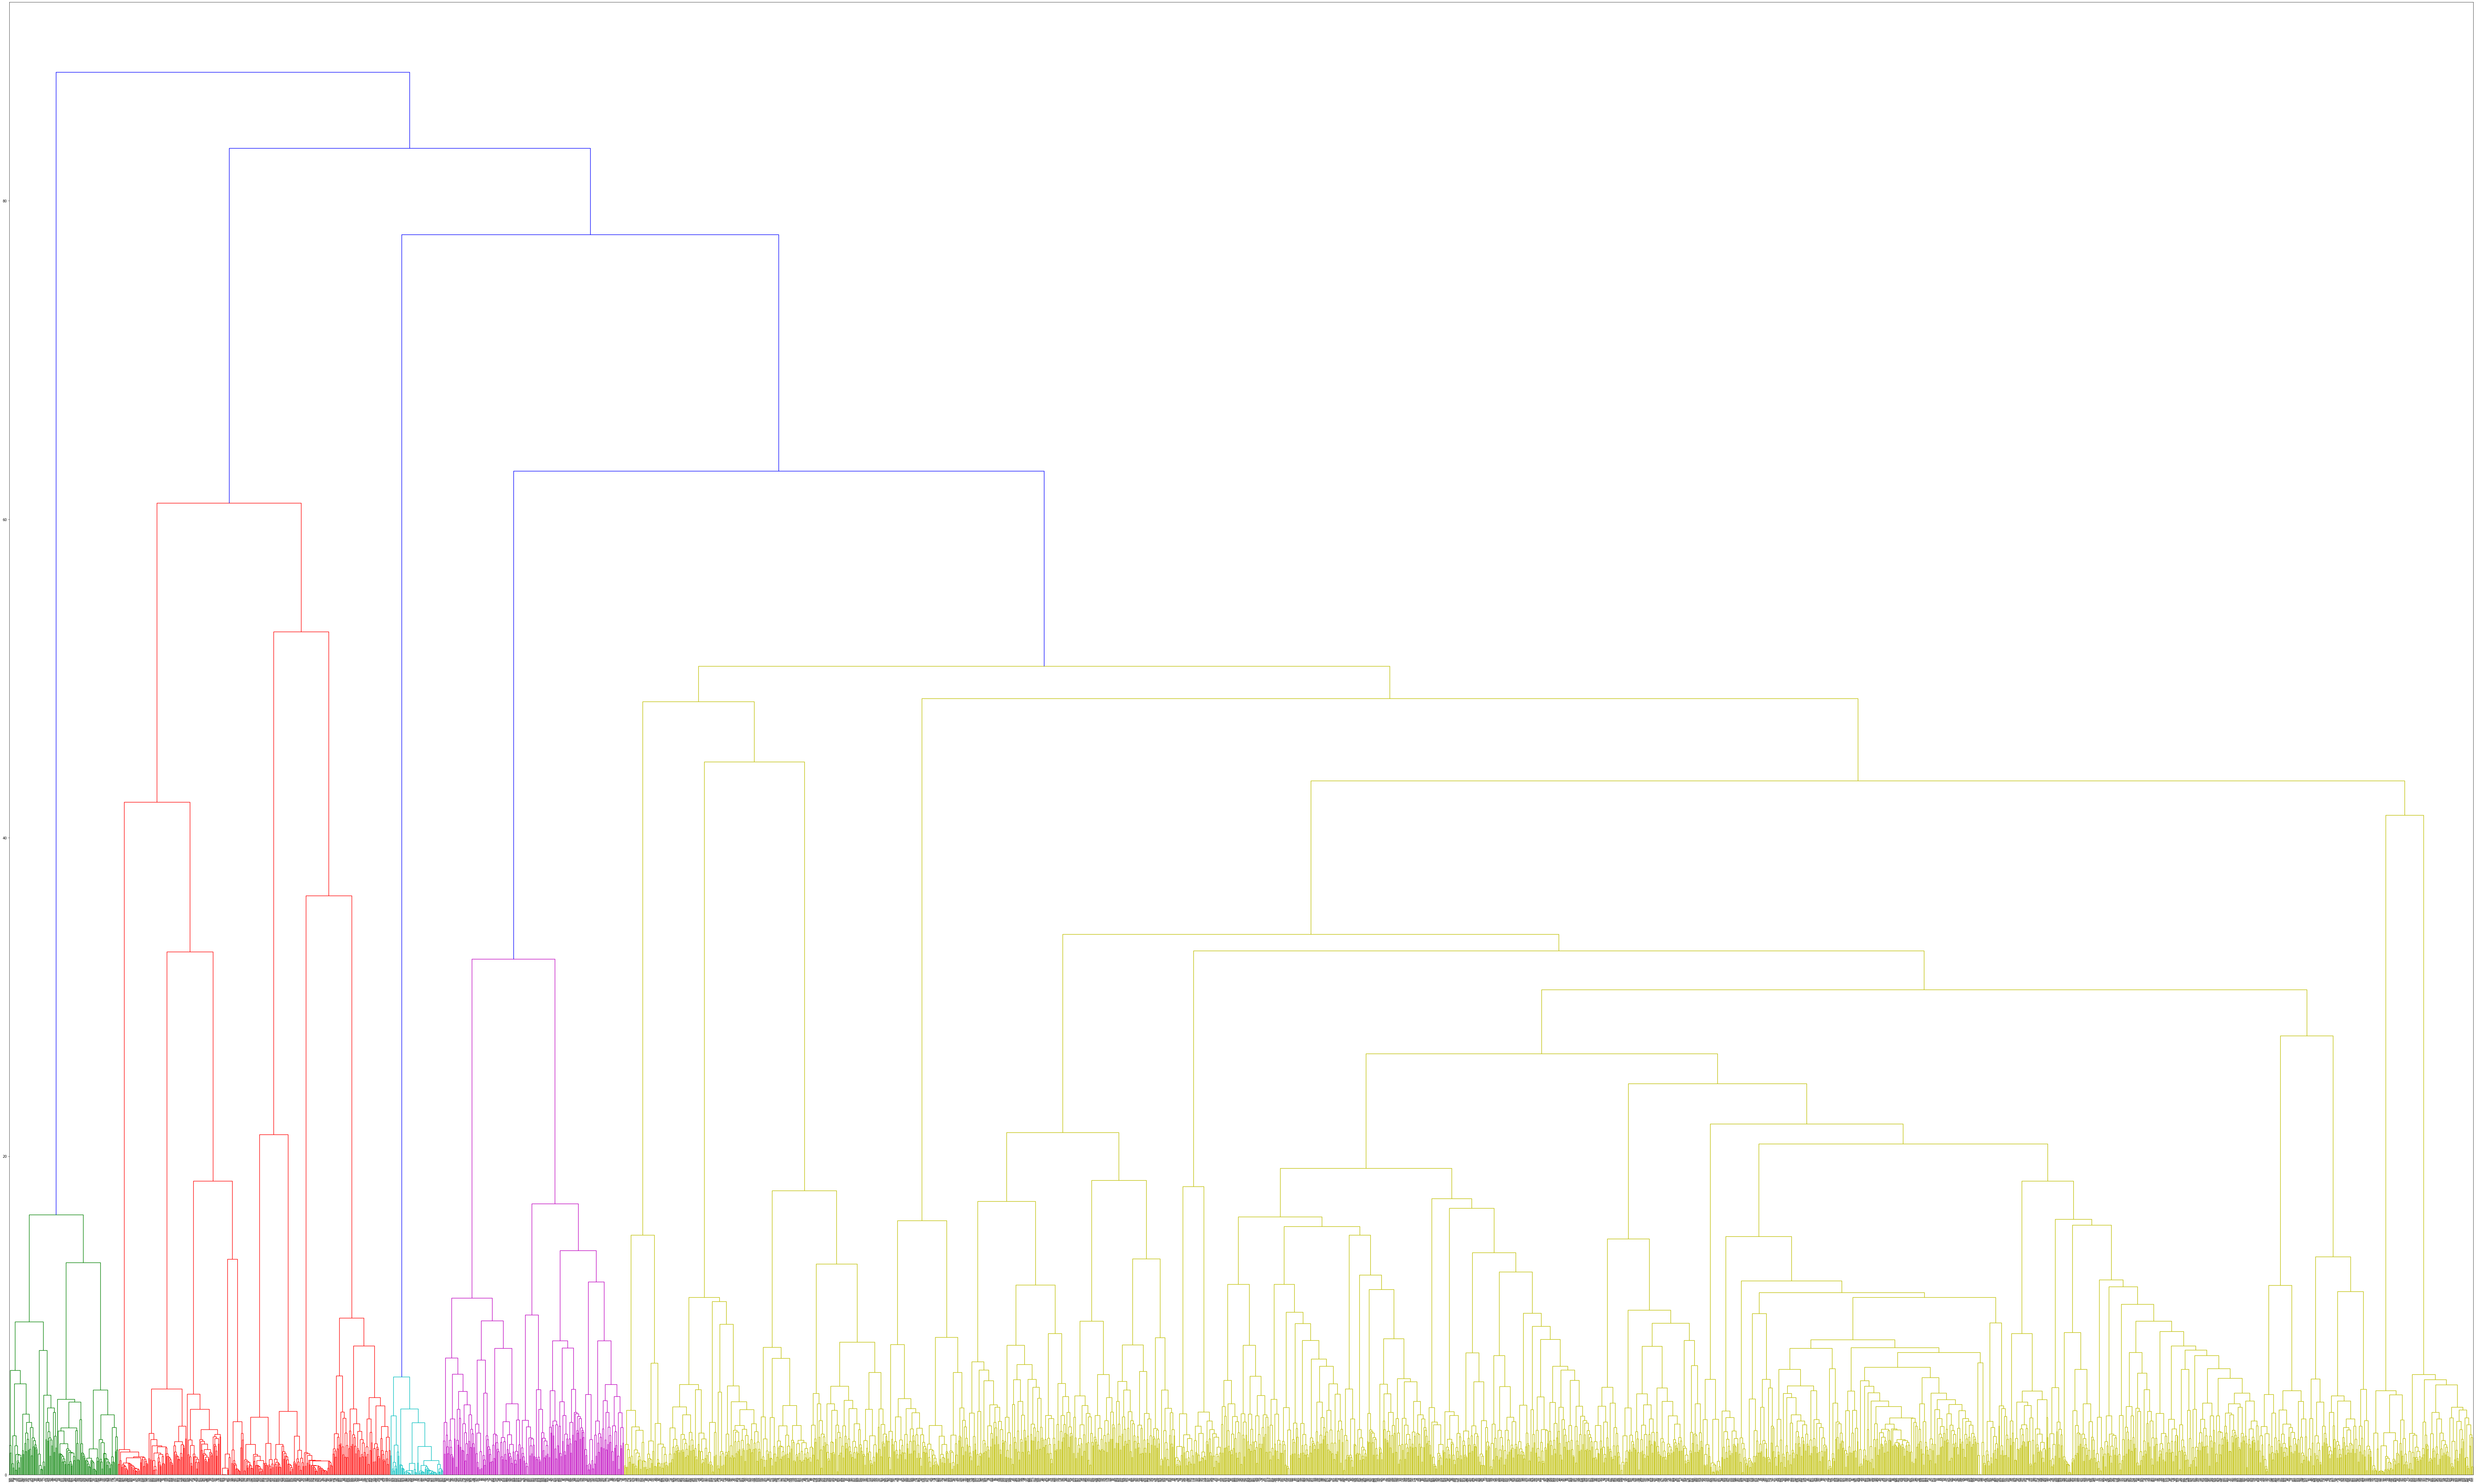

In [8]:
# visualize using matplotlip and save image of the dendrogram 

fig, ax = plt.subplots(figsize=(100, 60)) 
ax = dendrogram(linkage_matrix, orientation="top", get_leaves=True);

plt.tight_layout()

plt.savefig('dendrogram.png') #save figure as ward_clusters

In [8]:
df_results_dendrogram = pd.DataFrame(list(zip(den['leaves'],den['color_list'])),columns =['index_no', 'color_dendrogram']) # store results of clustering in a new df
df = df.merge(df_results_dendrogram, left_index=True, right_on='index_no') # add the labels to our original data frame

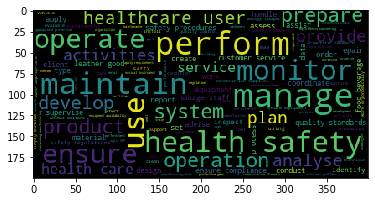

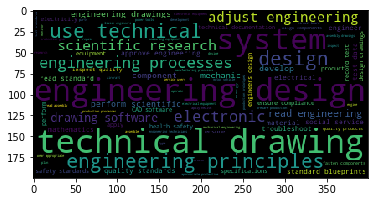

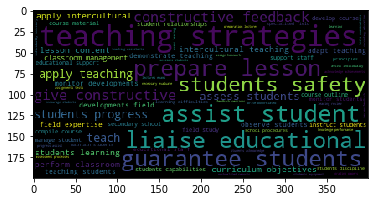

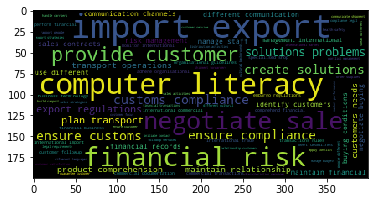

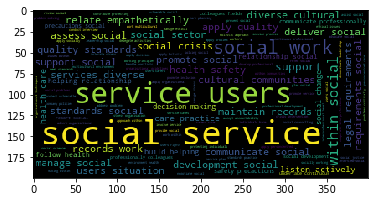

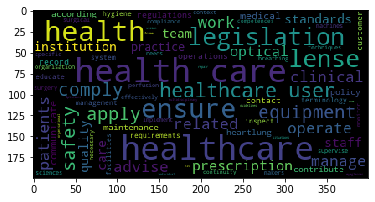

In [9]:
# we could analyse which words are used in each of the branches of the dendrogram
# i decided to create a word cloud for each of the six classes so we have an idea how the occupations were clustered and we can visualize each cluster
for i in df.color_dendrogram.unique(): # therefore, we interate through all six clusters and create again a corpus which contains all the skills used in this class
    df_small = df[df['color_dendrogram']==i]
    corpus_small = []
    for s in df_small.all_data:
        s = "".join(c for c in s if c not in string.punctuation)
        corpus_small.append(s)
    
    corpus_small = " ".join(str(x) for x in corpus_small)
    wordcloud = WordCloud(max_font_size=40).generate(corpus_small)
    plt.figure()
    plt.imshow(wordcloud)
    plt.show()
    name = "wordcloud_"+i+'.png'
    wordcloud.to_file(name)

In [ ]:
# The following cells indicate the trial of different corpuses and vectorizer settings I tried to create settings which 
# give equal sized classes, still yellow is by far the biggest cluster

In [6]:
# just skills 
print(df[df['color_dendrogram']=='y'].shape)
print(df[df['color_dendrogram']=='m'].shape)
print(df[df['color_dendrogram']=='c'].shape)
print(df[df['color_dendrogram']=='r'].shape)
print(df[df['color_dendrogram']=='g'].shape)
print(df[df['color_dendrogram']=='b'].shape)

(2207, 7)
(215, 7)
(62, 7)
(324, 7)
(129, 7)
(4, 7)


In [6]:
# just skills different settings!
print(df[df['color_dendrogram']=='y'].shape)
print(df[df['color_dendrogram']=='m'].shape)
print(df[df['color_dendrogram']=='c'].shape)
print(df[df['color_dendrogram']=='r'].shape)
print(df[df['color_dendrogram']=='g'].shape)
print(df[df['color_dendrogram']=='b'].shape)

(111, 7)
(152, 7)
(71, 7)
(62, 7)
(130, 7)
(5, 7)


In [29]:
# skills + description
print(df[df['color_dendrogram']=='y'].shape)
print(df[df['color_dendrogram']=='m'].shape)
print(df[df['color_dendrogram']=='c'].shape)
print(df[df['color_dendrogram']=='r'].shape)
print(df[df['color_dendrogram']=='g'].shape)
print(df[df['color_dendrogram']=='b'].shape)

(2467, 7)
(153, 7)
(184, 7)
(71, 7)
(62, 7)
(4, 7)


In [8]:
# just description
print(df[df['color_dendrogram']=='y'].shape)
print(df[df['color_dendrogram']=='m'].shape)
print(df[df['color_dendrogram']=='c'].shape)
print(df[df['color_dendrogram']=='r'].shape)
print(df[df['color_dendrogram']=='g'].shape)
print(df[df['color_dendrogram']=='b'].shape)

(0, 7)
(2798, 7)
(34, 7)
(35, 7)
(71, 7)
(3, 7)


In [11]:
# we can now use the set of skills to predict to which cluster an occupation belongs X-> skills used as features in form of tfidf
# y -> obtained lables
y = df.color_dendrogram

corpus = []
for s in df.skills_essential:
    s = "".join(c for c in s if c not in string.punctuation)
    corpus.append(s)
    
vectorizer = TfidfVectorizer(min_df=1, stop_words="english") 
X = vectorizer.fit_transform(corpus) # we use the tfidf matrix as a basis for our features

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) #train test split

In [12]:
classifier = RandomForestClassifier(n_estimators=500, random_state=0) #simple random forest with 500 trees
classifier.fit(X_train, y_train) # fit classifier given the training set
y_pred = classifier.predict(X_test) # make predictions for the test set

In [18]:
# analyse the results via accuracy and confusion matrix
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[  0   0   0   0   0   1]
 [  0   9   0   0   0   1]
 [  0   0  20   0   0   1]
 [  0   0   0  37   0   6]
 [  0   0   1   0  64   5]
 [  0   0   0   0   0 444]]
0.9745331069609507


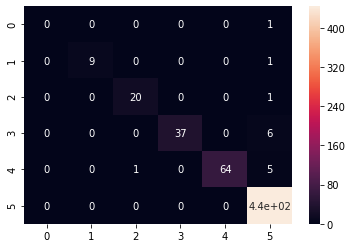

In [19]:
# save confusion matrix as png
ax= plt.subplot()
sns_plot = sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, ax = ax)
plt.savefig("confusion_matrix.png")